# Finding Heavy Traffic Indicators on I-94

We're going to analyze a dataset about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94).

John Hogue made the dataset available, and you can download it from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The goal of our analysis is **to determine a few indicators of heavy traffic on I-94**. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

In [1]:
import pandas as pd

# Read CSV file
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# Examine dataset
print(traffic.head())
print('\n')
print(traffic.tail())
print('\n')
print(traffic.info())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  


      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0 

The dataset has 9 columns and 48204 rows (excluding headers). All rows are filled with data. 
We can see that the `date_time` column is set with object data type. It should be converted to datetime.

In [2]:
# Convert data type of date_time column
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

Let's describe the meaning of each column in the dataset:
- `holiday`: Categorical US National holidays plus regional holiday, Minnesota State Fair
- `temp`: Numeric Average temp in kelvin
- `rain_1h`: Numeric Amount in mm of rain that occurred in the hour
- `snow_1h`: Numeric Amount in mm of snow that occurred in the hour
- `clouds_all`: Numeric Percentage of cloud cover
- `weather_main`: Categorical Short textual description of the current weather
- `weather_description`: Categorical Longer textual description of the current weather
- `date_time`: DateTime Hour of the data collected in local CST time
- `traffic_volume`: Numeric Hourly I-94 ATR 301 reported westbound traffic volume

## Analyzing Traffic Volume

The [dataset documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

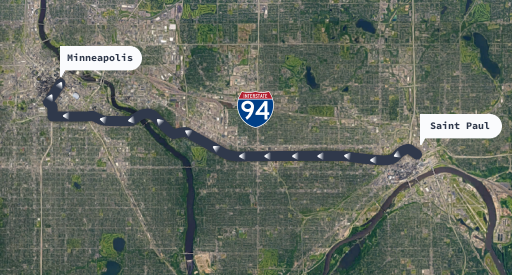

This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

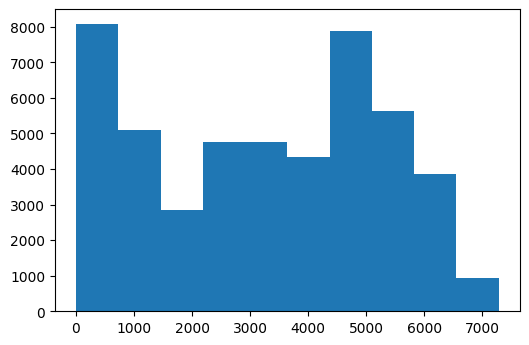

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Examine the distribution of the traffic_volume column
plt.hist(traffic['traffic_volume'])
plt.show()

In [4]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Hourly traffic volume varied from 0 to 7280 cars in the observation period. In which, for 25% of the time which might be the nighttime, number of car passed this road per hour was 1193 or less. On the other hand, in the other 25% of time which might be the daytime, this road faced heavy traffic with over 4933 cars per hour, approximately 4 times higher than the nighttime.

The above observation gives us a direction to analyze between nighttime and daytime.

## Traffic Volume: Day vs. Night

We'll start by dividing the dataset into two parts:
- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

In [5]:
import datetime as dt

In [6]:
# Isolate the nighttime and daytime data into 2 separated datasets
day = traffic[(traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)]
night = traffic[(traffic['date_time'].dt.hour < 7) | (traffic['date_time'].dt.hour >= 19)]

In [7]:
print(day.shape)
print(night.shape)

(23877, 9)
(24327, 9)


The difference in number of rows of 2 above datasets is a number of missing data.

In [8]:
traffic['recorded_hour'] = traffic['date_time'].dt.hour

In [9]:
traffic['recorded_hour'] = traffic['date_time'].dt.hour
missing_i = []
for i in range(1,48203):
    if ((traffic.iloc[i,-1] - traffic.iloc[i+1,-1]) != 23) and ((traffic.iloc[i,-1] - traffic.iloc[i+1,-1]) != -1):
        missing_i.append(i)

In [10]:
print(missing_i[:5])
print(missing_i[-5:])

[21, 23, 28, 60, 61]
[48071, 48111, 48172, 48192, 48194]


In [11]:
import numpy as np
print('Below is examples of missing data \(recorded_hour\):')
print('\n')
print(traffic.iloc[np.r_[21:25,48071:48073],:])


Below is examples of missing data \(recorded_hour\):


      holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
21       None  278.23      0.0      0.0           1        Clear   
22       None  278.12      0.0      0.0           1        Clear   
23       None  282.48      0.0      0.0           1        Clear   
24       None  291.97      0.0      0.0           1        Clear   
48071    None  284.25      0.0      0.0          90         Rain   
48072    None  284.25      0.0      0.0          90      Drizzle   

           weather_description           date_time  traffic_volume  \
21                sky is clear 2012-10-03 06:00:00            5673   
22                sky is clear 2012-10-03 08:00:00            6511   
23                sky is clear 2012-10-03 09:00:00            5471   
24                sky is clear 2012-10-03 12:00:00            5097   
48071    proximity shower rain 2018-09-25 16:00:00            6597   
48072  light intensity drizzle 2018-09-25 16:00:

Besides, we also investigated some duplicates in time recorded as below.

In [12]:
date_freq = {}
for i in range(0,48203):
    date = traffic.iloc[i,7]
    if date in date_freq:
        date_freq[date] += 1
    else:
        date_freq[date] = 1

In [13]:
date_duplicate = []
for key in date_freq:
    if date_freq[key] > 1:
        date_duplicate.append(key)

In [14]:
traffic_copy = traffic.iloc[:, np.r_[0:5,7:10]]
traffic_copy['date_time'] = traffic_copy['date_time'].map(lambda x: x.round(freq='H'))
traffic_copy['temp'] = traffic_copy['temp'].map(lambda x: round(x, 2))
traffic_copy['rain_1h'] = traffic_copy['rain_1h'].map(lambda x: round(x, 1))
traffic_copy['snow_1h'] = traffic_copy['snow_1h'].map(lambda x: round(x, 1))

# Duplicates by all columns except weather_main and weather_description
duplicates_ex_weather = traffic_copy[traffic_copy.duplicated(keep=False)]
duplicates_ex_weather

<ipython-input-14-2a4a0aa72af2>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-2a4a0aa72af2>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-2a4a0aa72af2>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-2a4a0aa

,holiday,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume,recorded_hour
178,None,281.25,0.0,0.0,99,2012-10-10 07:00:00,6793,7
179,None,281.25,0.0,0.0,99,2012-10-10 07:00:00,6793,7
180,None,280.10,0.0,0.0,99,2012-10-10 08:00:00,6283,8
181,None,280.10,0.0,0.0,99,2012-10-10 08:00:00,6283,8
182,None,279.61,0.0,0.0,99,2012-10-10 09:00:00,5680,9
...,...,...,...,...,...,...,...,...
48173,None,280.68,0.0,0.0,90,2018-09-29 19:00:00,3818,19
48192,None,283.48,0.0,0.0,90,2018-09-30 14:00:00,4380,14
48193,None,283.48,0.0,0.0,90,2018-09-30 14:00:00,4380,14
48194,None,283.84,0.0,0.0,75,2018-09-30 15:00:00,4302,15


In [15]:
n_duplicates_ex_weather = len(duplicates_ex_weather[duplicates_ex_weather['date_time'].isin(date_duplicate)]['date_time'].value_counts())

In [16]:
traffic_copy_2 = traffic.iloc[:, np.r_[0,2:10]]
traffic_copy_2['date_time'] = traffic_copy_2['date_time'].map(lambda x: x.round(freq='H'))
traffic_copy_2['rain_1h'] = traffic_copy_2['rain_1h'].map(lambda x: round(x, 1))
traffic_copy_2['snow_1h'] = traffic_copy_2['snow_1h'].map(lambda x: round(x, 1))

# Duplicates by all columns except temp
duplicates_ex_temp = traffic_copy_2[traffic_copy_2.duplicated(keep=False)]
duplicates_ex_temp

<ipython-input-16-b2cb9da3973d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-b2cb9da3973d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-b2cb9da3973d>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,holiday,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,recorded_hour
878,None,0.0,0.0,90,Clouds,overcast clouds,2012-11-04 01:00:00,730,1
879,None,0.0,0.0,90,Clouds,overcast clouds,2012-11-04 01:00:00,730,1
11202,None,0.0,0.0,90,Clouds,overcast clouds,2014-01-03 20:00:00,2427,20
11203,None,0.0,0.0,90,Clouds,overcast clouds,2014-01-03 20:00:00,2427,20
12498,None,0.0,0.0,1,Clear,sky is clear,2014-02-25 02:00:00,244,2
...,...,...,...,...,...,...,...,...,...
38677,None,0.0,0.0,90,Mist,mist,2017-11-05 01:00:00,629,1
39526,None,0.0,0.0,1,Clear,sky is clear,2017-12-05 18:00:00,3936,18
39527,None,0.0,0.0,1,Clear,sky is clear,2017-12-05 18:00:00,3936,18
48172,None,0.0,0.0,90,Clouds,overcast clouds,2018-09-29 19:00:00,3818,19


In [17]:
n_duplicates_ex_temp = len(duplicates_ex_temp[duplicates_ex_temp['date_time'].isin(date_duplicate)]['date_time'].value_counts())

In [18]:
print('Unique recorded hours: ', len(date_freq))
print('Unique recorded hours being duplicated: ', len(date_duplicate))
print('- Duplicates due to the multiple weather recorded: ', n_duplicates_ex_weather)
print('- Duplicates due to the difference in temperature recorded: ', n_duplicates_ex_temp)

Unique recorded hours:  40574
Unique recorded hours being duplicated:  5445
- Duplicates due to the multiple weather recorded:  5380
- Duplicates due to the difference in temperature recorded:  58


From above investigation, we'll do analysis based on the original dataset and dataset without duplucates.

Text(0, 0.5, 'Frequency')

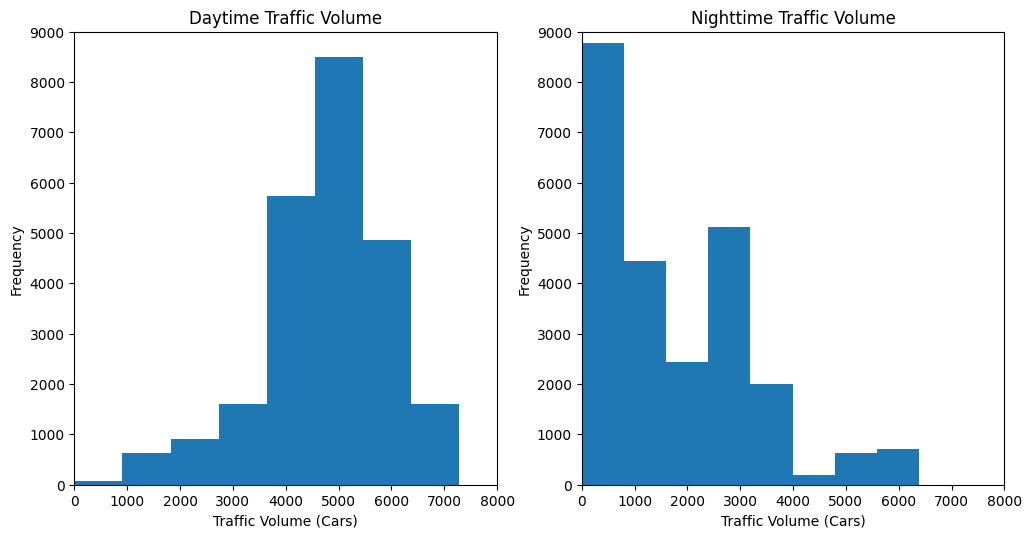

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(day['traffic_volume'], bins=8)
plt.ylim(0,9000)
plt.xlim(0,8000)
plt.title('Daytime Traffic Volume')
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(night['traffic_volume'], bins=8)
plt.ylim(0,9000)
plt.xlim(0,8000)
plt.title('Nighttime Traffic Volume')
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Frequency')

In [20]:
day_short = day[['date_time','traffic_volume']]
day_short_unique = day_short.drop_duplicates(keep='first')

In [21]:
night_short = night[['date_time','traffic_volume']]
night_short_unique = night_short.drop_duplicates(keep='first')

Text(0, 0.5, 'Frequency')

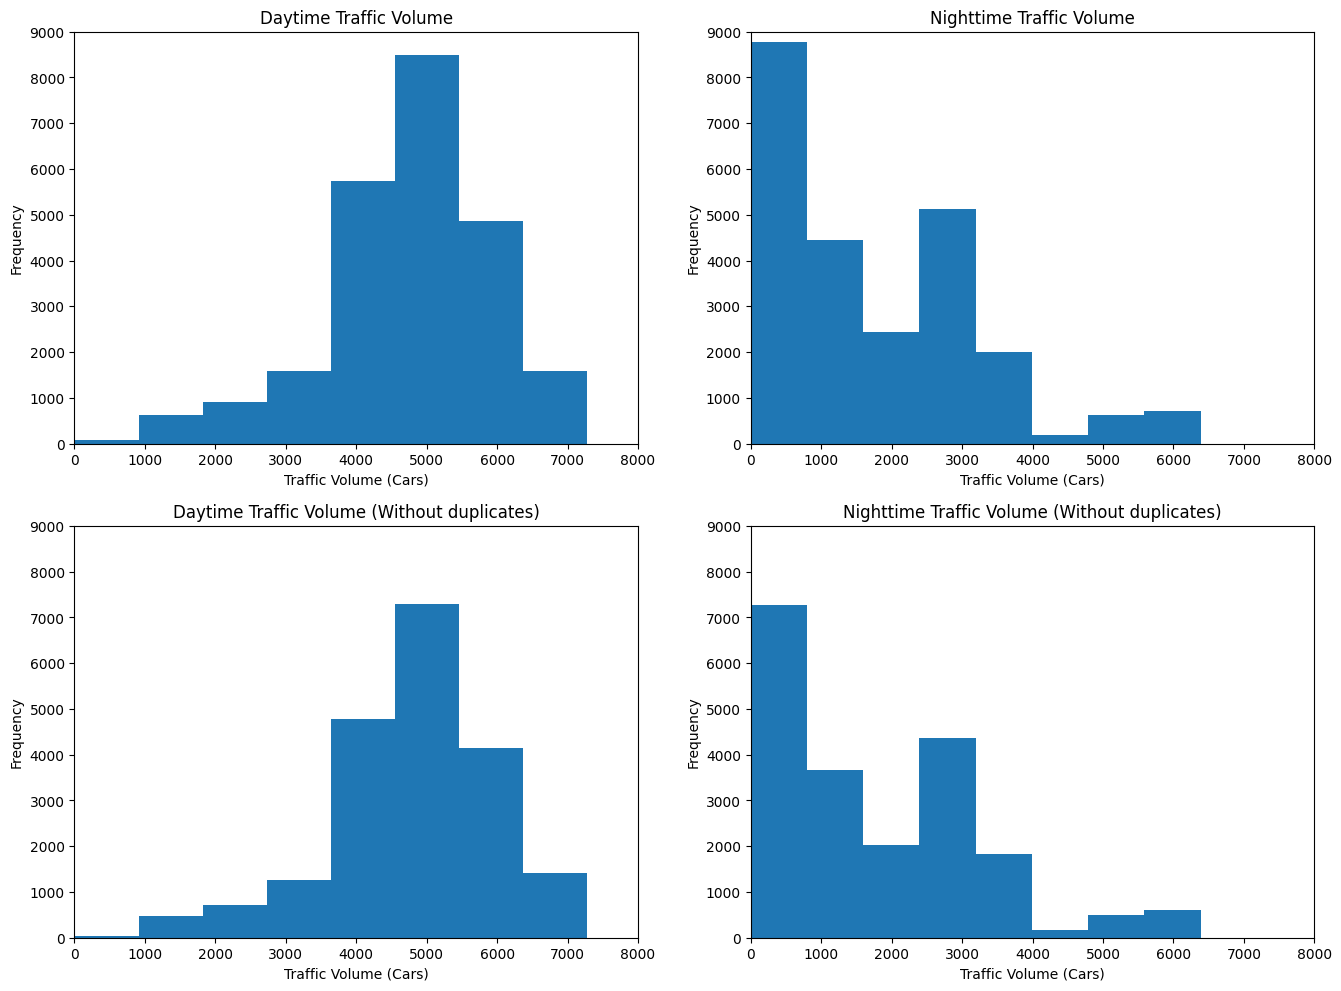

In [22]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
plt.hist(day['traffic_volume'], bins=8)
plt.ylim(0,9000)
plt.xlim(0,8000)
plt.title('Daytime Traffic Volume')
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Frequency')

plt.subplot(2,2,2)
plt.hist(night['traffic_volume'], bins=8)
plt.ylim(0,9000)
plt.xlim(0,8000)
plt.title('Nighttime Traffic Volume')
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Frequency')

plt.subplot(2,2,3)
plt.hist(day_short_unique['traffic_volume'], bins=8)
plt.ylim(0,9000)
plt.xlim(0,8000)
plt.title('Daytime Traffic Volume (Without duplicates)')
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Frequency')

plt.subplot(2,2,4)
plt.hist(night_short_unique['traffic_volume'], bins=8)
plt.ylim(0,9000)
plt.xlim(0,8000)
plt.title('Nighttime Traffic Volume (Without duplicates)')
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Frequency')

From the above grapth, we can see that there are no significant difference in traffic volume frequency between data with and without duplicates. 

The major traffic volume in the daytime is about 4000-6000 cars, causing heavy traffic. Meanwhile, heavy traffic in the nighttime is relatively rare. The typlical traffic volume in the nighttime stays around 3000 cars or less.

It is reasonable to use just daytime data to find indicators of heavy traffic.

## Time Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:
- Month
- Day of the week
- Time of day

### Month

In [23]:
# Create the month column and calculate the average traffic volume
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()

day_short_unique['month'] = day_short_unique['date_time'].dt.month
by_month_2 = day_short_unique.groupby('month').mean()

<ipython-input-23-1819562273c8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-1819562273c8>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(4300.0, 5000.0)

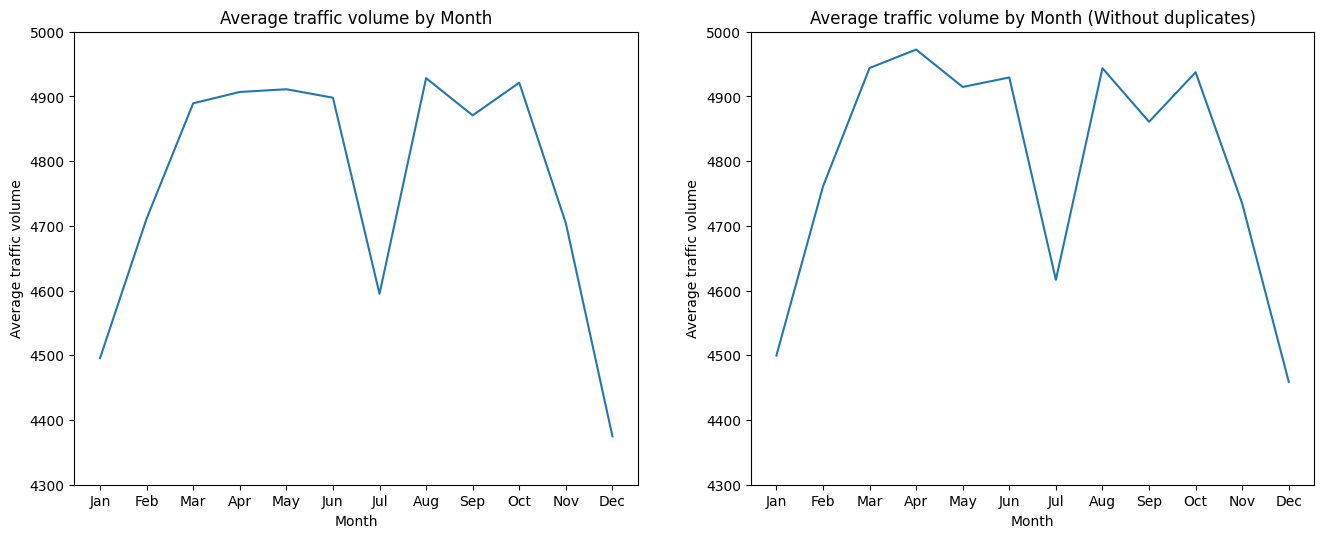

In [24]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(by_month['traffic_volume'])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Average traffic volume')
plt.xlabel('Month')
plt.title('Average traffic volume by Month')
plt.ylim(4300,5000)

plt.subplot(1,2,2)
plt.plot(by_month_2['traffic_volume'])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Average traffic volume')
plt.xlabel('Month')
plt.title('Average traffic volume by Month (Without duplicates)')
plt.ylim(4300,5000)

There is significant difference in the average traffic volume per hour between warm season (from March to October) and cold season (from November to February). The traffic is usually heavier during warm months compared to cold months. Notably, in July, the traffic volume decreased sharply which should be considered later.

### Day of Week

In [25]:
# Create the dayofweek column and calculate the average traffic volume
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()

day_short_unique['dayofweek'] = day_short_unique['date_time'].dt.dayofweek
by_dayofweek_2 = day_short_unique.groupby('dayofweek').mean()

<ipython-input-25-d7aaa3807aad>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-d7aaa3807aad>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(3350.0, 5500.0)

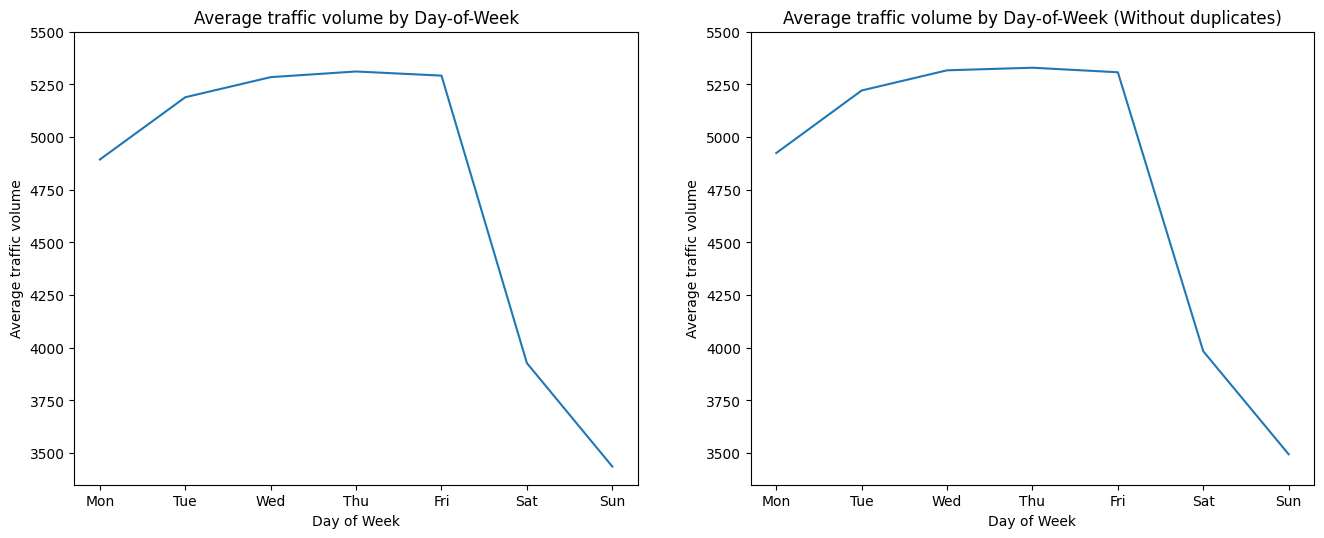

In [26]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(by_dayofweek['traffic_volume'])
plt.xticks([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Average traffic volume')
plt.xlabel('Day of Week')
plt.title('Average traffic volume by Day-of-Week')
plt.ylim(3350,5500)

plt.subplot(1,2,2)
plt.plot(by_dayofweek_2['traffic_volume'])
plt.xticks([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Average traffic volume')
plt.xlabel('Day of Week')
plt.title('Average traffic volume by Day-of-Week (Without duplicates)')
plt.ylim(3350,5500)

The graph shows heavy traffic of above 4750 cars per hour on business days (Monday to Friday). Meanwhile, on the weekend, the average traffic volume was just below 4000 cars.

### Time of Day

From the investigation about heavy traffic on business days, in this section, we'll analyze traffic volume by time of day for business days and weekend separately.

In [27]:
# Create the hour column and calculate the average traffic volume
day['hour'] = day['date_time'].dt.hour
by_hour_business = day[~day['dayofweek'].isin([5,6])].groupby('hour').mean()
by_hour_weekend = day[day['dayofweek'].isin([5,6])].groupby('hour').mean() 

day_short_unique['hour'] = day_short_unique['date_time'].dt.hour
by_hour_business_2 = day_short_unique[~day_short_unique['dayofweek'].isin([5,6])].groupby('hour').mean()
by_hour_weekend_2 = day_short_unique[day_short_unique['dayofweek'].isin([5,6])].groupby('hour').mean()                      

<ipython-input-27-dc5d23ef858b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-27-dc5d23ef858b>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1500.0, 6500.0)

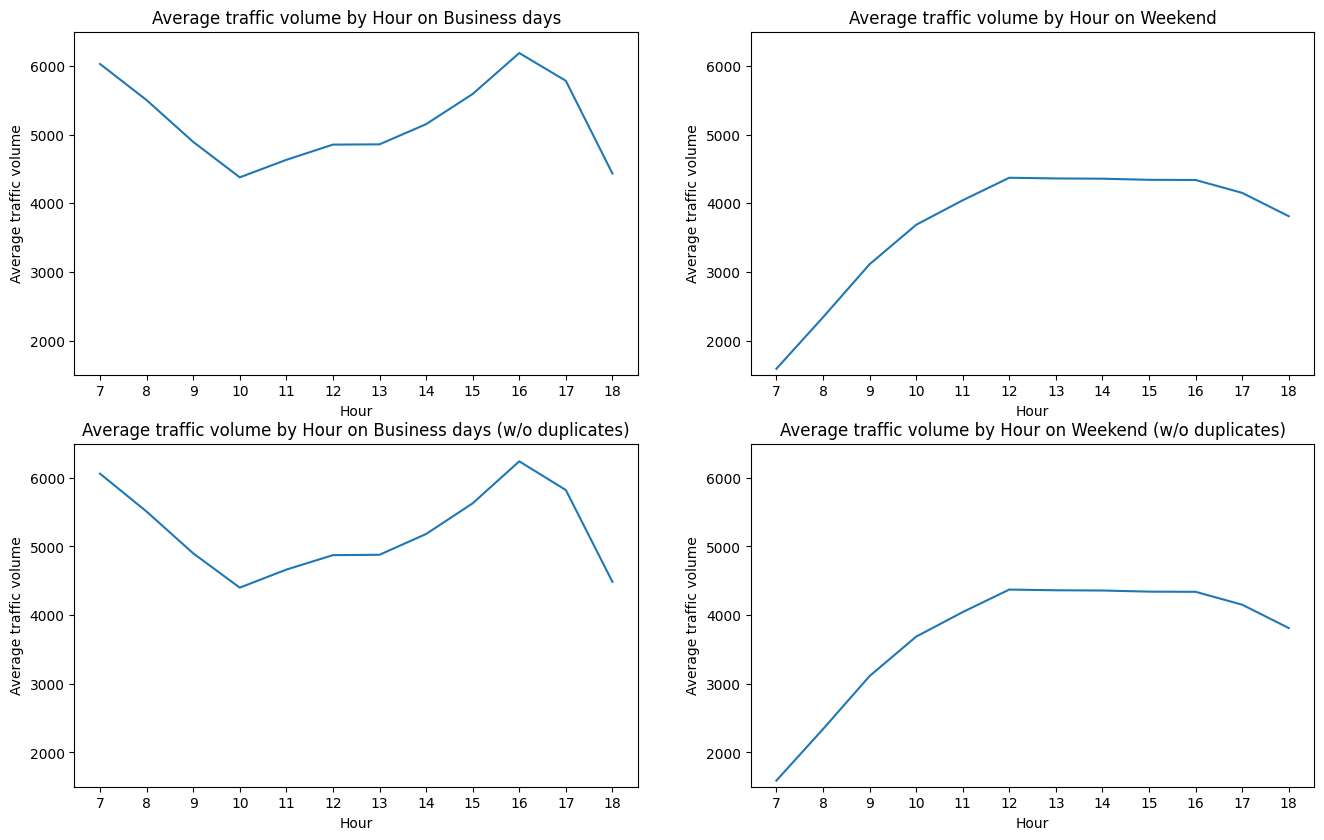

In [28]:
plt.figure(figsize=(16,10))
# With duplicates
plt.subplot(2,2,1)
plt.plot(by_hour_business['traffic_volume'])
plt.xticks(range(7,19))
plt.ylabel('Average traffic volume')
plt.xlabel('Hour')
plt.title('Average traffic volume by Hour on Business days')
plt.ylim(1500,6500)

plt.subplot(2,2,2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.xticks(range(7,19))
plt.ylabel('Average traffic volume')
plt.xlabel('Hour')
plt.title('Average traffic volume by Hour on Weekend')
plt.ylim(1500,6500)

# Without duplicates
plt.subplot(2,2,3)
plt.plot(by_hour_business_2['traffic_volume'])
plt.xticks(range(7,19))
plt.ylabel('Average traffic volume')
plt.xlabel('Hour')
plt.title('Average traffic volume by Hour on Business days (w/o duplicates)')
plt.ylim(1500,6500)

plt.subplot(2,2,4)
plt.plot(by_hour_weekend['traffic_volume'])
plt.xticks(range(7,19))
plt.ylabel('Average traffic volume')
plt.xlabel('Hour')
plt.title('Average traffic volume by Hour on Weekend (w/o duplicates)')
plt.ylim(1500,6500)

- For business days: The rush hours are all time in the daytime. Especially, heavy traffic reached at the time people go to work/go to scholl (from 7 a.m to 8 a.m) and off time (from 4 p.m to 5 p.m)
- For weekend: in the daytime, the average traffic volume per hour increased steadly from 7 a.m to 12 p.m and stayed stable after 12 p.m when people go out for out-door activities.

So far, we've focused on finding time indicators for heavy traffic, and we reached the following conclusions:
- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 7 and 16.

## Weather Indicators

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

A few of these columns are numerical so let's start by looking up their correlation values with `traffic_volume`.

Before that, we'll drop duplicates in the dataset with numerical columns only.

In [29]:
day_num_unique = day[['date_time', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].drop_duplicates(keep='first')

In [30]:
day_num_unique

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2012-10-02 09:00:00,288.28,0.00,0.0,40,5545
1,2012-10-02 10:00:00,289.36,0.00,0.0,75,4516
2,2012-10-02 11:00:00,289.58,0.00,0.0,90,4767
3,2012-10-02 12:00:00,290.13,0.00,0.0,90,5026
4,2012-10-02 13:00:00,291.14,0.00,0.0,75,4918
...,...,...,...,...,...,...
48192,2018-09-30 14:00:00,283.48,0.00,0.0,90,4380
48194,2018-09-30 15:00:00,283.84,0.00,0.0,75,4302
48196,2018-09-30 16:00:00,284.38,0.00,0.0,75,4283
48197,2018-09-30 17:00:00,284.79,0.00,0.0,75,4132


In [31]:
date_freq_num = {}
for i in range(0,20214):
    date = day_num_unique.iloc[i,0]
    if date in date_freq_num:
        date_freq_num[date] += 1
    else:
        date_freq_num[date] = 1
        
date_duplicate_num = []
for key in date_freq_num:
    if date_freq_num[key] > 1:
        date_duplicate_num.append(key)

In [32]:
day_num_unique[day_num_unique['date_time'].isin(date_duplicate_num)]

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
11337,2014-01-09 16:00:00,265.73,0.0,0.0,40,6421
11338,2014-01-09 16:00:00,266.47,0.0,0.0,64,6421
11387,2014-01-11 16:00:00,271.04,0.0,0.0,20,4546
11388,2014-01-11 16:00:00,272.02,0.0,0.0,64,4546
11496,2014-01-15 16:00:00,263.15,0.0,0.0,90,6252
...,...,...,...,...,...,...
29193,2016-12-16 18:00:00,261.65,0.0,0.0,90,2344
29256,2016-12-18 14:00:00,251.51,0.0,0.0,1,3437
29257,2016-12-18 14:00:00,251.23,0.0,0.0,1,3437
32425,2017-04-06 14:00:00,283.68,0.0,0.0,1,5446


There are 128 rows with duplicated dates. Records are different from each other in weather indicators. Since this number is relatively small, we'll use average values for these duplicated rows. 

In [33]:
day_num_unique = day_num_unique.groupby('date_time').mean().reset_index()

In [34]:
day_num_unique[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr()['traffic_volume']

temp              0.117724
rain_1h           0.004298
snow_1h          -0.005608
clouds_all       -0.012232
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

Between numerical weather indicators, temperature seems to have the strongest correlation with `traffic_volume`. Let's deeper focus on the relationship between `temp` and `traffic_volume`.

Text(0, 0.5, 'Temperature (in Kelvin)')

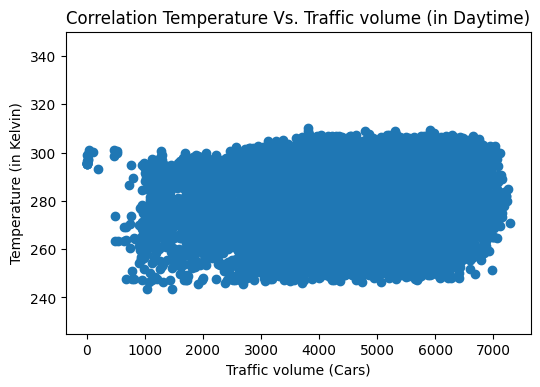

In [35]:
plt.scatter(day_num_unique['traffic_volume'],
           day_num_unique['temp'])

plt.ylim(225,350)
plt.title('Correlation Temperature Vs. Traffic volume (in Daytime)')
plt.xlabel('Traffic volume (Cars)')
plt.ylabel('Temperature (in Kelvin)')

We did not find any reliability of heavy traffic on the temperature

In conclusion, there is no reliable weather numerical indicators of heavy traffic.

## Weather Types

To see if we can find more useful data, we'll look next at the categorical weather-related columns: `weather_main` and `weather_description`.

We're going to calculate the average traffic volume associated with each unique value in these two columns. 

In [36]:
day_cate_unique = day[['date_time','weather_main','weather_description','traffic_volume']].drop_duplicates(keep='first')

In [37]:
day_cate_unique

,date_time,weather_main,weather_description,traffic_volume
0,2012-10-02 09:00:00,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,Clouds,broken clouds,4918
...,...,...,...,...
48194,2018-09-30 15:00:00,Rain,proximity shower rain,4302
48195,2018-09-30 15:00:00,Drizzle,light intensity drizzle,4302
48196,2018-09-30 16:00:00,Rain,light rain,4283
48197,2018-09-30 17:00:00,Clouds,broken clouds,4132


In [38]:
date_freq_cate = {}
for i in range(0,23813):
    date = day_cate_unique.iloc[i,0]
    if date in date_freq_cate:
        date_freq_cate[date] += 1
    else:
        date_freq_cate[date] = 1
        
date_duplicate_cate = []
for key in date_freq_cate:
    if date_freq_cate[key] > 1:
        date_duplicate_cate.append(key)

In [39]:
day_cate_unique[day_cate_unique['date_time'].isin(date_duplicate_cate)]

,date_time,weather_main,weather_description,traffic_volume
178,2012-10-10 07:00:00,Rain,light rain,6793
179,2012-10-10 07:00:00,Drizzle,light intensity drizzle,6793
180,2012-10-10 08:00:00,Rain,light rain,6283
181,2012-10-10 08:00:00,Drizzle,light intensity drizzle,6283
182,2012-10-10 09:00:00,Rain,light rain,5680
...,...,...,...,...
48112,2018-09-27 07:00:00,Drizzle,light intensity drizzle,6589
48192,2018-09-30 14:00:00,Rain,light rain,4380
48193,2018-09-30 14:00:00,Drizzle,light intensity drizzle,4380
48194,2018-09-30 15:00:00,Rain,proximity shower rain,4302


As duplicated dates contain multiple weather types and they are 6243 rows in the total of 23813 rows, we'll seperately analyze on 2 datasets with and without these duplicates.

In [40]:
day_cate_unique_wo = day_cate_unique[~day_cate_unique['date_time'].isin(date_duplicate_cate)]

In [41]:
# Calculate the average traffic volume
## With duplicates
by_main = day_cate_unique.groupby('weather_main').mean().reset_index()
by_des = day_cate_unique.groupby('weather_description').mean().reset_index()

## Without duplicates
by_main_wo = day_cate_unique_wo.groupby('weather_main').mean().reset_index()
by_des_wo = day_cate_unique_wo.groupby('weather_description').mean().reset_index()

Text(0.5, 1.0, 'Traffic volume by Weather main (Without duplicates)')

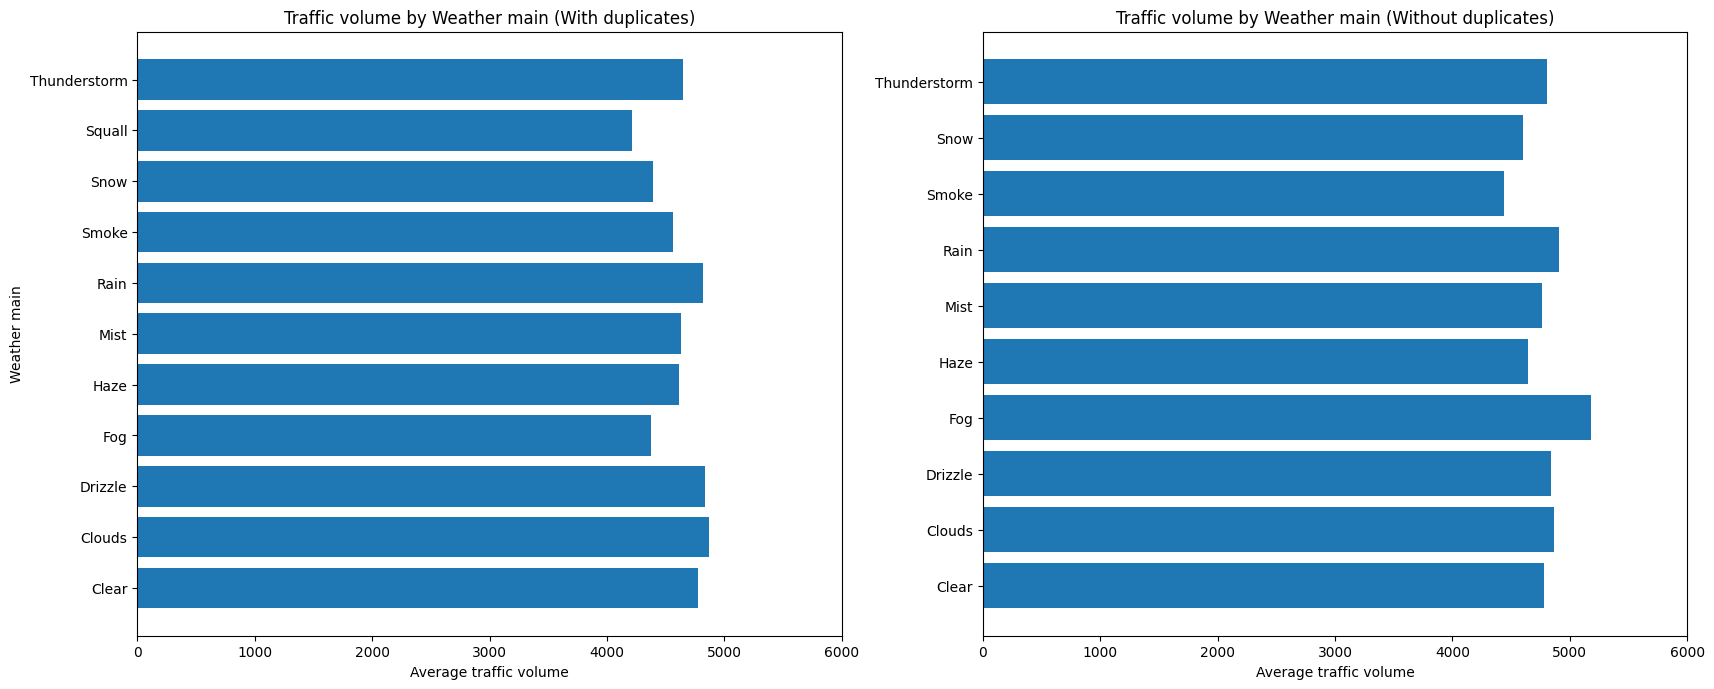

In [42]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.barh(by_main['weather_main'],
         by_main['traffic_volume'])
plt.xlim(0,6000)
plt.xlabel('Average traffic volume')
plt.ylabel('Weather main')
plt.title('Traffic volume by Weather main (With duplicates)')

plt.subplot(1,2,2)
plt.barh(by_main_wo['weather_main'],
         by_main_wo['traffic_volume'])
plt.xlim(0,6000)
plt.xlabel('Average traffic volume')
plt.title('Traffic volume by Weather main (Without duplicates)')

- Based on the dataset with multiple weather recorded, there is no weather type has significant affect on heavy traffic.
- Meanwhile, based on the dataset without duplicates, the traffic is the heaviest in the Fog weather with the average traffic volume exceeding 5000 cars.

Text(0.5, 1.0, 'Traffic volume by Weather description (Without duplicates)')

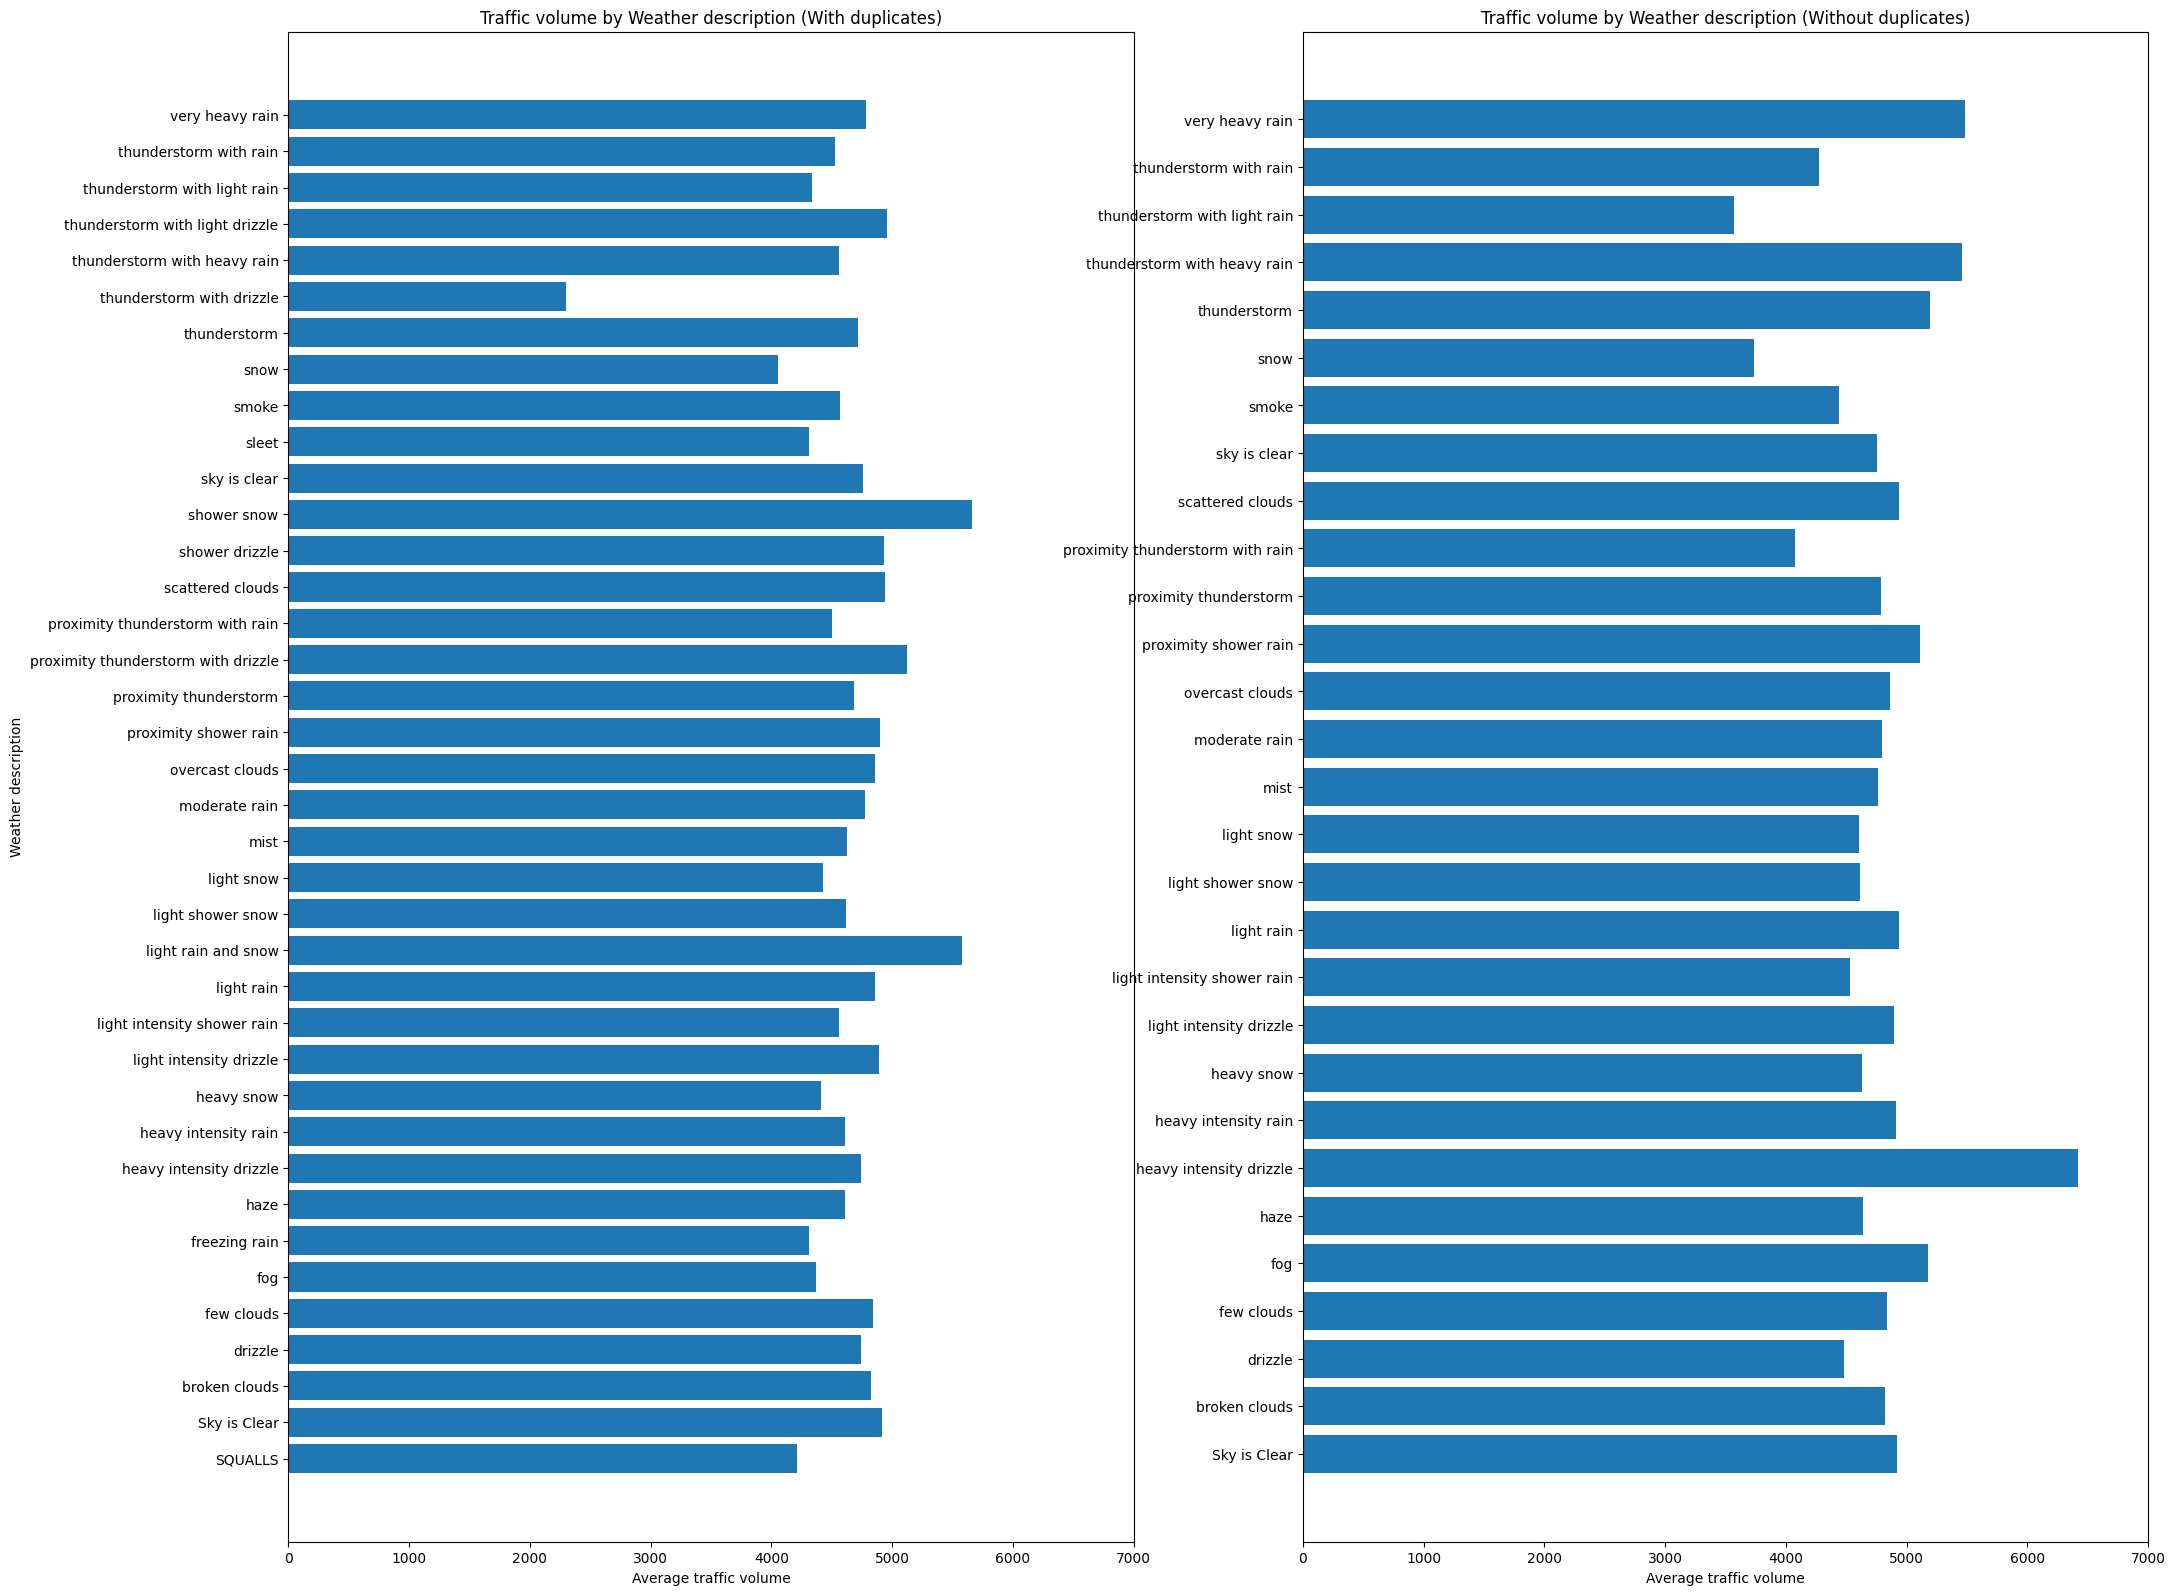

In [43]:
plt.figure(figsize=(24,20))

plt.subplot(1,2,1)
plt.barh(by_des['weather_description'],
         by_des['traffic_volume'])
plt.xlim(0,7000)
plt.xlabel('Average traffic volume')
plt.ylabel('Weather description')
plt.title('Traffic volume by Weather description (With duplicates)')

plt.subplot(1,2,2)
plt.barh(by_des_wo['weather_description'],
         by_des_wo['traffic_volume'])
plt.xlim(0,7000)
plt.xlabel('Average traffic volume')
plt.title('Traffic volume by Weather description (Without duplicates)')

- Based on the dataset with multiple weather recorded, the traffic is much heavier in *Shower snow* and *light rain and snow* with the average traffic volume exceeding 5000 cars.
- Meanwhile, based on the dataset without duplicates, the traffic is much heavier in *very heavy rain*, *thunderstorm with heavy rain*, and *heavy intensity drizzle* with the average traffic volume exceeding 5000 cars. Notably, in the *heavy intensity drizzle* weather, the average number of cars per hour even reach around 6500.

The above analysis brings us a concern about the combination of terrifying weathers that make traffic worse (for example: heavy snow with heavy rain and drizzle). The analysis will be clearer when we consider weather combination.

# Conclusion

In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

1. **Time indicators**
- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to the weekends.
- On business days, the rush hours are around 7 and 16.

2. **Weather indicators**
- Shower snow
- Light rain and snow
- Heavy rain
- Heavy intensity drizzle

***Moreover, the analysis will be clearer if we investigate deeper in the weather combination.***